# Предсказание коэффициента восстановления золота из золотосодержащей руды.

#### Описание проекта 

   Данные находятся в трёх файлах: 
1. gold_recovery_train_new.csv — обучающая выборка; 
2. gold_recovery_test_new.csv — тестовая выборка; 
3. gold_recovery_full_new.csv — исходные данные. 
    Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи. 
    Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков. 
    Исходный датасет содержит обучающую и тестовую выборки со всеми признаками. 
    В вашем распоряжении сырые данные: их просто выгрузили из хранилища. Прежде чем приступить к построению модели, проверьте по нашей инструкции их на корректность. 

## Подготовьте данные 

###  1.Открытие и изучение файлов

In [1]:
!pip install catboost

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_absolute_error, make_scorer
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [3]:
# открываем датасеты, за индексы принимаем дату.
try:
    train = pd.read_csv('gold_recovery_train_new.csv', sep=',', index_col='date')
    test = pd.read_csv('gold_recovery_test_new.csv', sep=',', index_col='date')
    full = pd.read_csv('gold_recovery_full_new.csv', sep=',', index_col='date')
except:
    train = pd.read_csv('/datasets/gold_recovery_train_new.csv', sep=',', index_col='date') 
    test = pd.read_csv('/datasets/gold_recovery_test_new.csv', sep=',', index_col='date') 
    full = pd.read_csv('/datasets/gold_recovery_full_new.csv', sep=',', index_col='date')

In [4]:
# Изучаем данные, проверяем дубликаты
print('Явные дубликаты:', full.duplicated().sum())

Явные дубликаты: 0


In [5]:
# Смотрим общую информацию  наличие пропусков
train.info()
print(train.isna().sum().sort_values(ascending=False))

<class 'pandas.core.frame.DataFrame'>
Index: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  float64
 8   final.output.tail_au                             

In [6]:
test.info()
print(test.isna().sum().sort_values(ascending=False))

<class 'pandas.core.frame.DataFrame'>
Index: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5290 non-null

In [7]:
full.info()
     

<class 'pandas.core.frame.DataFrame'>
Index: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_pb                         19438 non-null  float64
 2   final.output.concentrate_sol                        19228 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19438 non-null  float64
 6   final.output.tail_pb                                19338 non-null  float64
 7   final.output.tail_sol                               19433 non-null  float64
 8   final.output.tail_au                             

1. Мы видим, что данные не сожержат дубликатов.
2. Есть пропуски в разных колонках
3. В датасетах различается количество столбцов
4. Тип данных в порядке.

### 2. Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака. Опишите выводы. 

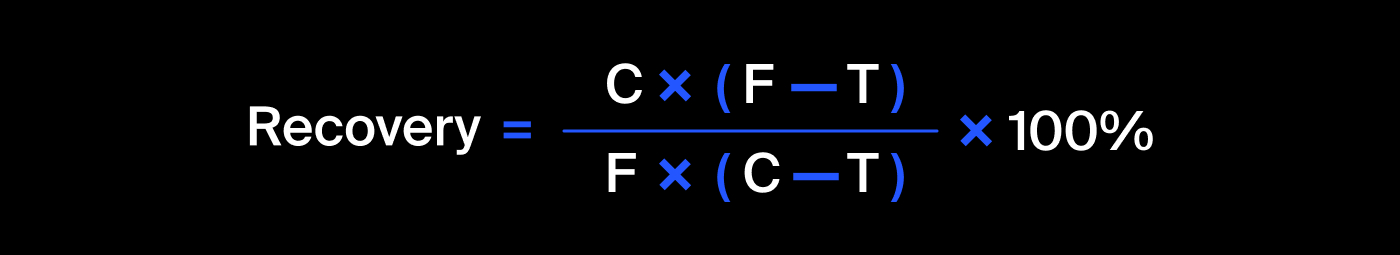

    где:
    C — доля золота в концентрате после флотации/очистки;
    F — доля золота в сырье/концентрате до флотации/очистки;
    T — доля золота в отвальных хвостах после флотации/очистки.
    
    Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат.

In [8]:
# Рассчитаем эффективность обогащения 
c =  train['rougher.output.concentrate_au']
f = train['rougher.input.feed_au']
t = train['rougher.output.tail_au']
recovery = ((c*(f-t))/(f*(c -t))) * 100
# Вычислим MAE
print(mean_absolute_error(train['rougher.output.recovery'], recovery))

9.73512347450521e-15


Мы видим, что значение MAE стремиться к 0 - это значит, что значения признака rougher.output.recovery верны.


###   3. Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся? 

In [9]:
#Вычислим различия по признакам между обучающим и тестовым датасетами.
abcent_columns = set(train.columns) - set(test.columns)
train[abcent_columns].info()

<class 'pandas.core.frame.DataFrame'>
Index: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   rougher.calculation.au_pb_ratio                     14149 non-null  float64
 1   secondary_cleaner.output.tail_pb                    14139 non-null  float64
 2   rougher.output.tail_au                              14149 non-null  float64
 3   rougher.calculation.floatbank10_sulfate_to_au_feed  14148 non-null  float64
 4   rougher.output.recovery                             14149 non-null  float64
 5   final.output.concentrate_au                         14149 non-null  float64
 6   rougher.calculation.sulfate_to_au_concentrate       14148 non-null  float64
 7   primary_cleaner.output.tail_pb                      14134 non-null  float64
 8   final.output.tail_pb                             

В тестовой выборке отсутвтвуют параметры продукта, расчётные характеристики, включая целевые признаки. По условиям задания эти данные получаются в результате технологического процесса, и поэтому будет необходимость их убирать для обучния модели.

### 4. Проведите предобработку данных

Заполним пропуски, остальное перед обучением модели.иcходя из информации в задании, что соседние по времени параметры часто похожи, выбираю метод ffill


In [10]:
train = train.fillna(method='ffill')
test = test.fillna(method='ffill')
full = full.fillna(method='ffill')

In [11]:
print(train.isna().sum())
print('-----------------------------------------------------------------')
print(test.isna().sum())
print('-----------------------------------------------------------------')
print(full.isna().sum())

final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
final.output.recovery                         0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 86, dtype: int64
-----------------------------------------------------------------
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level     

ИТОГ:Изучив данные, обнаружены пропуски и различия по количеству признаков в выборках train и test.
Значения признака rougher.output.recovery указаны верно. Пропуски были заполнены методов ffill.


## Анализ данных

### 1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы. 

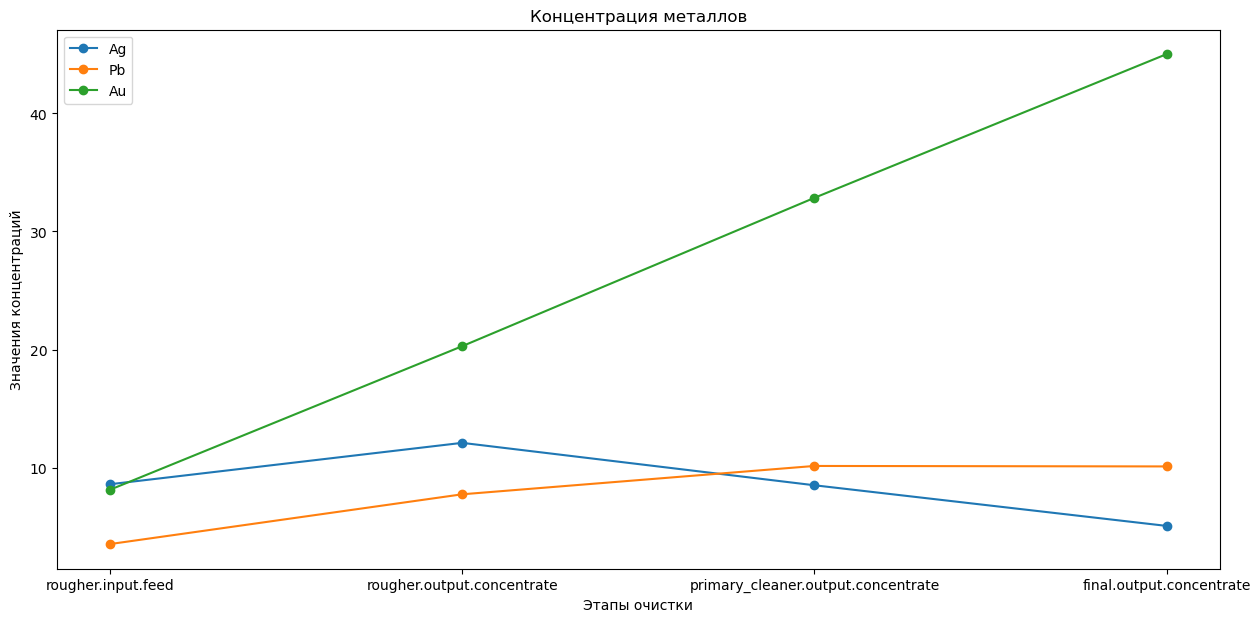

In [12]:
#Построим график по медианным значениям концентраций металлов
ag_conc = full[['rougher.input.feed_ag','rougher.output.concentrate_ag', 
                'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']].median()
pb_conc = full[['rougher.input.feed_pb','rougher.output.concentrate_pb', 
                'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']].median()
au_conc = full[['rougher.input.feed_au','rougher.output.concentrate_au', 
                'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']].median()
ag_conc.plot(figsize = (15, 7), label = 'Ag', style = 'o-')
pb_conc.plot(figsize = (15, 7), label = 'Pb', style = 'o-')
au_conc.plot(figsize = (15, 7), label = 'Au', style = 'o-')
plt.title('Концентрация металлов')
plt.legend()
plt.xlabel('Этапы очистки')
plt.ylabel('Значения концентраций')
x_ticks = [0,1,2,3]
x_labels = ['rougher.input.feed', 'rougher.output.concentrate', 'primary_cleaner.output.concentrate', 'final.output.concentrate'] 
plt.xticks(ticks=x_ticks, labels=x_labels)

plt.show()

На графике видим, что концентрация золота закономерно увеличивается в процессе обогащения и после второй очистки имеет наивысший результат. Колебания концентрации других металов могут быть связаны с разными химическими реакциями во время произв.процесса.

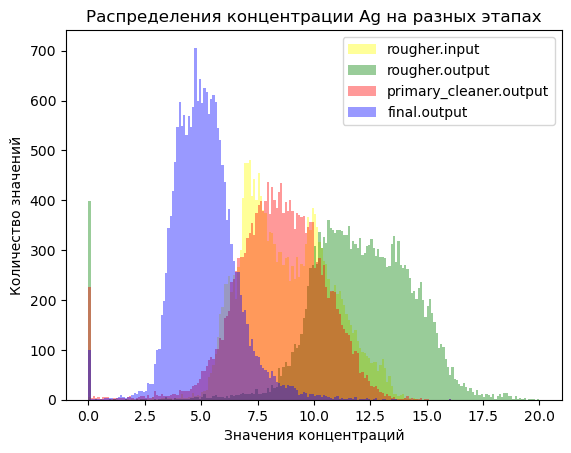

In [13]:
plt.hist(full['rougher.input.feed_ag'],  bins=200, color='yellow', label='rougher.input', range=(0, 20), alpha=0.4)
plt.hist(full['rougher.output.concentrate_ag'],  bins=200, color='green', label='rougher.output', range=(0, 20), alpha=0.4)
plt.hist(full['primary_cleaner.output.concentrate_ag'],  bins=200, color='red', label='primary_cleaner.output', range=(0, 20), alpha=0.4)
plt.hist(full['final.output.concentrate_ag'],  bins=200, color='blue', label='final.output', range=(0, 20), alpha=0.4)
plt.title('Распределения концентрации Ag на разных этапах')
plt.xlabel('Значения концентраций')
plt.ylabel('Количество значений')
plt.legend()
plt.show()

Концентрация Ag уменьшается к завершению цикла обогащения.

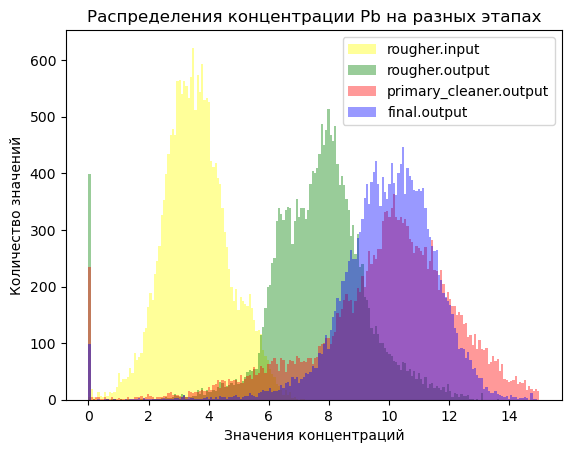

In [14]:
plt.hist(full['rougher.input.feed_pb'],  bins=200, color='yellow', label='rougher.input', range=(0, 15), alpha=0.4)
plt.hist(full['rougher.output.concentrate_pb'],  bins=200, color='green', label='rougher.output', range=(0, 15), alpha=0.4)
plt.hist(full['primary_cleaner.output.concentrate_pb'],  bins=200, color='red', label='primary_cleaner.output', range=(0, 15), alpha=0.4)
plt.hist(full['final.output.concentrate_pb'],  bins=200, color='blue', label='final.output', range=(0, 15), alpha=0.4)
plt.title('Распределения концентрации Pb на разных этапах')
plt.xlabel('Значения концентраций')
plt.ylabel('Количество значений')
plt.legend()
plt.show()

Концентрация Pb увеличивается после первой очистки

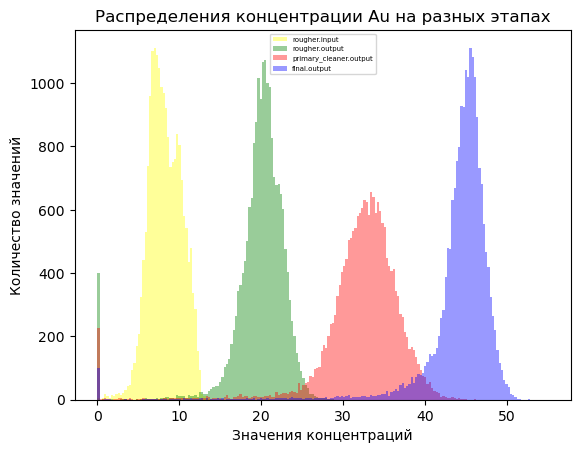

In [15]:
plt.hist(full['rougher.input.feed_au'],  bins=200, color='yellow', label='rougher.input', range=(0, 55), alpha=0.4)
plt.hist(full['rougher.output.concentrate_au'],  bins=200, color='green', label='rougher.output', range=(0, 55), alpha=0.4)
plt.hist(full['primary_cleaner.output.concentrate_au'],  bins=200, color='red', label='primary_cleaner.output', range=(0, 55), alpha=0.4)
plt.hist(full['final.output.concentrate_au'],  bins=200, color='blue', label='final.output', range=(0, 55), alpha=0.4)
plt.title('Распределения концентрации Au на разных этапах')
plt.xlabel('Значения концентраций')
plt.ylabel('Количество значений')
plt.legend(fontsize=5)
plt.show()

Концентрация золота увеличивается в процессе обогащения и после второй очистки имеет наивысший результат.

    Итог: целью процесса обогащения в данном случае является ощичение золота(повышение концентрации) от других составляющих золотоносной руды. При этом в процессе могут повышаться или понижаться концентрации сопутствующих металлов, в зависимотсти от реагентов и по иным причинам.
    Мы видим нулевые концентрации, это выбросы, которые обрабатываются ниже.

### 2.Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

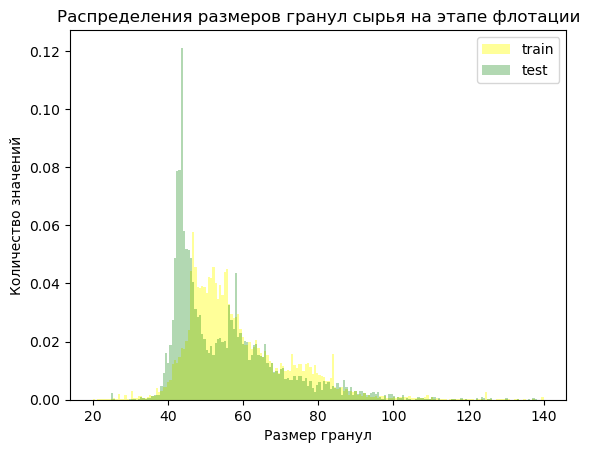

In [16]:
# Построим плотности распределения, тк объемы выборок отличаются.
plt.hist(train['rougher.input.feed_size'], bins=200, color='yellow', label='train', range=(20, 140), alpha=0.4, density=True)
plt.hist(test['rougher.input.feed_size'], bins=200, color='green', label='test', range=(20, 140), alpha=0.3, density=True)
plt.title('Распределения размеров гранул сырья на этапе флотации')
plt.xlabel('Размер гранул')
plt.ylabel('Количество значений')
plt.legend()
plt.show()

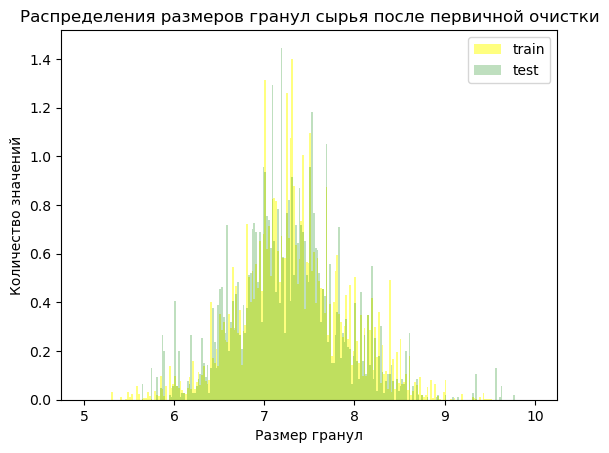

In [17]:
plt.hist(train['primary_cleaner.input.feed_size'], bins=250, color='yellow', label='train', range=(5, 10), alpha=0.5, density=True)
plt.hist(test['primary_cleaner.input.feed_size'], bins=250, color='green', label='test', range=(5, 10), alpha=0.25, density=True)
plt.title('Распределения размеров гранул сырья после первичной очистки')
plt.xlabel('Размер гранул')
plt.ylabel('Количество значений')
plt.legend()
plt.show()

Распределения размеров гранул сырья на обучающей и тестовой выборках очень похожи между собой.

### 3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.  

In [18]:
#Вытащим нужные признаки
rougher_input_feed = full['rougher.input.feed_ag'] + full['rougher.input.feed_pb'] + full['rougher.input.feed_au']
rougher_output_conc = full['rougher.output.concentrate_pb']+full['rougher.output.concentrate_ag']+full['rougher.output.concentrate_au']
primary_cleaner_output_conc = full['primary_cleaner.output.concentrate_au']+full['primary_cleaner.output.concentrate_ag']+full['primary_cleaner.output.concentrate_pb']
final_output_conc = full['final.output.concentrate_au']+full['final.output.concentrate_ag']+full['final.output.concentrate_pb']


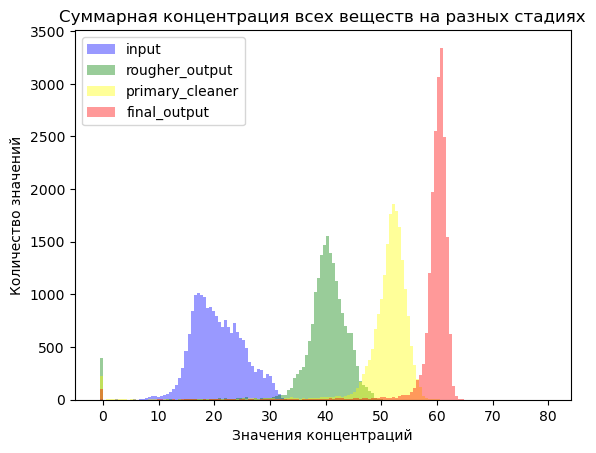

In [19]:
plt.hist(rougher_input_feed, bins=150, color='blue', label='input', range=(-1, 80), alpha=0.4)
plt.hist(rougher_output_conc, bins=150, color='green', label='rougher_output', range=(-1, 80), alpha=0.4)
plt.hist(primary_cleaner_output_conc, bins=150, color='yellow', label='primary_cleaner', range=(-1, 80), alpha=0.4)
plt.hist(final_output_conc, bins=150, color='red', label='final_output', range=(-1, 80), alpha=0.4)
plt.title('Суммарная концентрация всех веществ на разных стадиях')
plt.xlabel('Значения концентраций')
plt.ylabel('Количество значений')
plt.legend()
plt.show()

Суммарная концентрация вещества увеличивается с каждым этапом очистки. После второй очистки распределение концентраций веществ достигает максимума по сравнению с предыдущими стадиями.

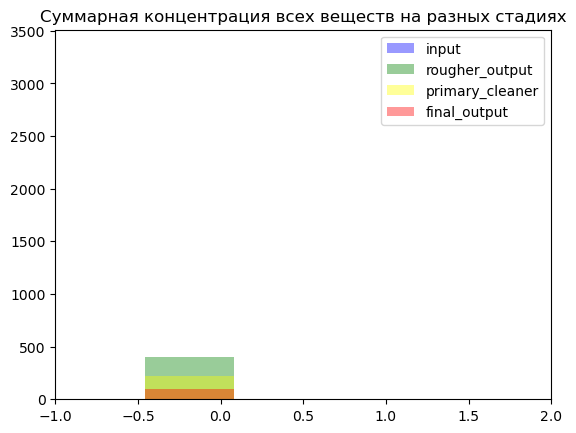

In [20]:
# Видим на графике значения около нуля, приблизим график.
plt.hist(rougher_input_feed, bins=150, color='blue', label='input', range=(-1, 80), alpha=0.4)
plt.hist(rougher_output_conc, bins=150, color='green', label='rougher_output', range=(-1, 80), alpha=0.4)
plt.hist(primary_cleaner_output_conc, bins=150, color='yellow', label='primary_cleaner', range=(-1, 80), alpha=0.4)
plt.hist(final_output_conc, bins=150, color='red', label='final_output', range=(-1, 80), alpha=0.4)
plt.title('Суммарная концентрация всех веществ на разных стадиях')
plt.legend()
plt.xlim([-1, 2])
plt.show()

Мы видим, что суммарные концентрции очень близки к 0 и даже есть отрицательные значения, эти аномалии стоит удалить.

In [21]:
# Удалим аномалии
def anomaly(data):
    data = data[(data['rougher.input.feed_ag'] >= 1) &
            (data['rougher.input.feed_pb'] >= 1) &
            (data['rougher.input.feed_sol'] >= 1) &
            (data['rougher.input.feed_au'] >= 1) &
            (data['rougher.output.concentrate_ag'] >= 1) &
            (data['rougher.output.concentrate_pb'] >= 1) &
            (data['rougher.output.concentrate_sol'] >= 1) &
            (data['rougher.output.concentrate_au'] >= 1) &
            (data['primary_cleaner.output.concentrate_ag'] >= 1) &
            (data['primary_cleaner.output.concentrate_pb'] >= 1) &
            (data['primary_cleaner.output.concentrate_sol'] >= 1) &
            (data['primary_cleaner.output.concentrate_au'] >= 1) &
            (data['final.output.concentrate_ag'] >= 1) &
            (data['final.output.concentrate_pb'] >= 1) &
            (data['final.output.concentrate_sol'] >= 1) &
            (data['final.output.concentrate_au'] >= 1)]
    
    return data
train = anomaly(train)
full = anomaly(full)
#аналогично удаляю из датафрейма test концентрации до 1:
test = test[(test['rougher.input.feed_ag'] >= 1) &
            (test['rougher.input.feed_pb'] >= 1) &
            (test['rougher.input.feed_sol'] >= 1) &
            (test['rougher.input.feed_au'] >= 1)]

ИТОГ: Концентрация золота закономерно увеличивается в процессе обогащения. Также суммарная концентрация вещества увеличивается с каждым этапом очистки.


## Построение модели


Перед построение модели данные нужно подготовить.
Из-за выявленных аномалий подготовку данных для обучения проведем в этом этапе.

In [22]:
# Удалим признаки, которых нет в тестовой выборке
train.drop(abcent_columns, axis=1, inplace=True)
# Верну в train и добавлю в test целевые признаки.
train = train.join(full[['final.output.recovery', 'rougher.output.recovery']], how='left')
test = test.join(full[['final.output.recovery', 'rougher.output.recovery']], how='left')

In [23]:
list(train.columns)

['primary_cleaner.input.sulfate',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.xanthate',
 'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_a_level',
 'primary_cleaner.state.floatbank8_b_air',
 'primary_cleaner.state.floatbank8_b_level',
 'primary_cleaner.state.floatbank8_c_air',
 'primary_cleaner.state.floatbank8_c_level',
 'primary_cleaner.state.floatbank8_d_air',
 'primary_cleaner.state.floatbank8_d_level',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air',
 'rough

In [24]:
# Разделим выборки на признаки и целевые признаки
features_train = train.drop(['final.output.recovery', 'rougher.output.recovery'], axis=1)
target_rougher_train = train['rougher.output.recovery']
target_final_train = train['final.output.recovery']

features_test = test.drop(['final.output.recovery', 'rougher.output.recovery'], axis=1) 
target_rougher_test = test['rougher.output.recovery']
target_final_test = test['final.output.recovery']

In [25]:
 #Масштабируем признаки  
pd.options.mode.chained_assignment = None
scaler = StandardScaler()
scaler.fit(features_train[features_train.columns])
features_train[features_train.columns] = scaler.transform(features_train[features_train.columns])
features_test[features_train.columns] = scaler.transform(features_test[features_train.columns])

### 1.Напишите функцию для вычисления итоговой sMAPE. 

In [26]:
def smape(target, predict):
    return (np.mean(abs(target - predict) / ((abs(target) + abs(predict)) / 2)) * 100)
    
def final_smape(smape_rougher, smape_final):
    return 0.25*smape_rougher + 0.75*smape_final 

### 2.Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы

In [27]:
#  Используем метод make_scorer для преобразования smape в оценочную метрику для использвания при кросс-валидации
score = make_scorer(smape, greater_is_better = False) 

In [28]:
# Строим Dummy модель и обучаем

model_dummy = DummyRegressor()
model_dummy_rougher = model_dummy.fit(features_train, target_rougher_train)
model_dummy_final = model_dummy.fit(features_train, target_final_train)
predicted_test_rougher = model_dummy_rougher.predict(features_test)
predicted_test_final = model_dummy_final.predict(features_test)

rouger_smape_dummy = smape(target_rougher_test, predicted_test_rougher)
final_smape_dummy = smape(target_final_test, predicted_test_final)

result = final_smape(rouger_smape_dummy, final_smape_dummy)
print('sMAPE на тестовой выборке =', round(result,3))

sMAPE на тестовой выборке = 12.737


Итоговое sMAPE при использовании константной модели = 12,737

In [29]:
# Строим LinearRegression и обучаем
params_lr = {}
model_lr_rougher = RandomizedSearchCV(LinearRegression(), params_lr, scoring=score, n_jobs=-1, random_state=12345, cv=3, verbose=10)
model_lr_final = RandomizedSearchCV(LinearRegression(), params_lr, scoring=score, n_jobs=-1, random_state=12345, cv=3, verbose=10)
model_lr_rougher.fit(features_train, target_rougher_train)
model_lr_final.fit(features_train, target_final_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


RandomizedSearchCV(cv=3, estimator=LinearRegression(), n_jobs=-1,
                   param_distributions={}, random_state=12345,
                   scoring=make_scorer(smape, greater_is_better=False),
                   verbose=10)

In [30]:
# Строим CatBoostRegressor
params_cbr = {
    'learning_rate': [0.01, 0.1],
    'depth': [None] + [i for i in range(2, 12)],
    'n_estimators': [i for i in range(50, 200)]
}
model_cbr_rougher = RandomizedSearchCV(CatBoostRegressor(random_state=12345), params_cbr, n_iter=10, scoring=score, random_state=12345, n_jobs=-1, cv=3, verbose=10)
model_cbr_final = RandomizedSearchCV(CatBoostRegressor(random_state=12345), params_cbr, n_iter=10, scoring=score, random_state=12345, n_jobs=-1, cv=3, verbose=10)
# Обучаем CatBoostRegressor
model_cbr_rougher.fit(features_train, target_rougher_train)
model_cbr_final.fit(features_train, target_final_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
0:	learn: 7.5164369	total: 141ms	remaining: 11.4s
1:	learn: 7.3153315	total: 145ms	remaining: 5.8s
2:	learn: 7.1273848	total: 149ms	remaining: 3.92s
3:	learn: 6.9650957	total: 155ms	remaining: 3.02s
4:	learn: 6.8000219	total: 158ms	remaining: 2.44s
5:	learn: 6.6801314	total: 162ms	remaining: 2.06s
6:	learn: 6.5684856	total: 167ms	remaining: 1.79s
7:	learn: 6.4624820	total: 171ms	remaining: 1.58s
8:	learn: 6.3507335	total: 175ms	remaining: 1.42s
9:	learn: 6.2502357	total: 179ms	remaining: 1.29s
10:	learn: 6.1776625	total: 183ms	remaining: 1.18s
11:	learn: 6.0966765	total: 187ms	remaining: 1.09s
12:	learn: 6.0265646	total: 190ms	remaining: 1.01s
13:	learn: 5.9600436	total: 194ms	remaining: 944ms
14:	learn: 5.9009640	total: 199ms	remaining: 889ms
15:	learn: 5.8466108	total: 203ms	remaining: 835ms
16:	learn: 5.7952200	total: 206ms	remaining: 788ms
17:	learn: 5.7533370	total: 210ms	remaining: 746ms
18:	learn: 5.7114636	total: 214m

RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostRegressor object at 0x000001FCC2FC7220>,
                   n_jobs=-1,
                   param_distributions={'depth': [None, 2, 3, 4, 5, 6, 7, 8, 9,
                                                  10, 11],
                                        'learning_rate': [0.01, 0.1],
                                        'n_estimators': [50, 51, 52, 53, 54, 55,
                                                         56, 57, 58, 59, 60, 61,
                                                         62, 63, 64, 65, 66, 67,
                                                         68, 69, 70, 71, 72, 73,
                                                         74, 75, 76, 77, 78, 79, ...]},
                   random_state=12345,
                   scoring=make_scorer(smape, greater_is_better=False),
                   verbose=10)

In [34]:
params_rfr = {
    'n_estimators':[i for i in range(10, 100)],
    'max_depth': [None] + [i for i in range(2, 11)]
}
model_rfr_rougher = RandomizedSearchCV(RandomForestRegressor(random_state=12345), params_rfr, n_iter=10, random_state=12345, scoring=score, n_jobs=-1, cv=3, verbose=10)
model_rfr_final = RandomizedSearchCV(RandomForestRegressor(random_state=12345), params_rfr, n_iter=10, random_state=12345, scoring=score, n_jobs=-1, cv=3, verbose=10)

# Обучаем DRandomForestRegressor
model_rfr_rougher.fit(features_train, target_rougher_train)
model_rfr_final.fit(features_train, target_final_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=12345),
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 2, 3, 4, 5, 6, 7, 8,
                                                      9, 10],
                                        'n_estimators': [10, 11, 12, 13, 14, 15,
                                                         16, 17, 18, 19, 20, 21,
                                                         22, 23, 24, 25, 26, 27,
                                                         28, 29, 30, 31, 32, 33,
                                                         34, 35, 36, 37, 38, 39, ...]},
                   random_state=12345,
                   scoring=make_scorer(smape, greater_is_better=False),
                   verbose=10)

In [35]:
# Определяем самую удачную модель
lr_rougher = model_lr_rougher.best_score_
cbr_rougher = model_cbr_rougher.best_score_
rfr_rougher = model_rfr_rougher.best_score_
lr_final = model_lr_final.best_score_
cbr_final = model_cbr_final.best_score_
rfr_final = model_rfr_final.best_score_


print('LinearRegression лучший результат rougher =', -lr_rougher)
print('CatBoostRegressor лучший результат rougher =', -cbr_rougher)
print('RandomForestRegressor лучший результат rougher =', -rfr_rougher)
print()

print('LinearRegression лучший результат final =', -lr_final)
print('CatBoostRegressor лучший результат final =', -cbr_final)
print('RandomForestRegressor лучший результат final =', -rfr_final)

LinearRegression лучший результат rougher = 10.435831710777265
CatBoostRegressor лучший результат rougher = 7.481009727384154
RandomForestRegressor лучший результат rougher = 7.704603494813685

LinearRegression лучший результат final = 13.394385520866606
CatBoostRegressor лучший результат final = 9.669444261549897
RandomForestRegressor лучший результат final = 9.68483243082182


Выбираем CatBoostRegressor за самый лучший результат. CatBoostRegressor лучший результат rougher = 7,48, лучший результат final = 9,67

In [36]:
# Вычислим итоговое sMAPE для лучшей модели
smape_cbt = final_smape(cbr_rougher, cbr_final)
print('CatBoostRegressor итоговое sMAPE =', -smape_cbt)

CatBoostRegressor итоговое sMAPE = 9.12233562800846


итоговое sMAPE на тренировочной выборке = 9.122

#### Проверим результаты на тестовой выборке

In [37]:
# Получаем предсказания по лучшей модели для test
predicted_rougher = model_cbr_rougher.predict(features_test)
predicted_final = model_cbr_final.predict(features_test)

#вычисляем иоговое sMAPE
rouger_smape_test = smape(target_rougher_test, predicted_rougher)
final_smape_test = smape(target_final_test, predicted_final)

res_smape = final_smape(rouger_smape_test, final_smape_test)
print('sMAPE на тестовой выборке =', round(res_smape,3))


sMAPE на тестовой выборке = 6.424


    Выводы:
    По сравнению с Dummy моделью метрики других моделей лучше - модели вменяемые. Итоговый sMAPE на константной модели =  12,737
    Модель градиентного бустинга CatBoostRegressor оказалось лучшей, ее симметричная средняя абсолютная процентная ошибка самая маленькая, на тестовой выборке показатель улучшается. sMAPE на тестовой выборке = 6,424.
    Прототипом модели машинного обучения для «Цифры» выбираем CatBoostRegressor.